# Problema





> Dada su alta letalidad (el COVID-19 registra aprox. un 7% comparada con otros virus), es importante determinar las condiciones de pacientes que pueden conllevar mayores factores de vulnerabilidad para asi poder tomar acciones de prevencion y cuidado dirigidas a ciertos sectores sociodemograficos de la poblacion en EEUU.


#Hipotésis


>Crear un modelo de prediccion que nos permita determinar que factores sociodemograficos conllevan un mayor grado de vulnerabilidad midiendo la tasa de causalidad de eventos (necesidad de internamiento en hospital, ingreso a UCI, fallecimiento).
---
>Un modelo de forecasting, basandonos en los factores temporales (estacionalidad del tiempo,medidas preventivas del gobierno) y sociales (edad,sexo,raza) disponibles nos puede permitir realizar proyecciones en un futuro proximo (semanal,1M,3M), lo cual permite tomar acciones de planificacion por parte del sector sanitario.
---
>Encontrar atributos y patrones que inciden con mayor fuerza en la letalidad de la enfermedad (edad,sexo,raza,enfermedades preexistentes,ingreso a UCI)
para la predicción del riesgo de muerte en el paciente.

#Análisis descriptivo - COVID 19

In [ ]:
from google.colab import files

In [ ]:
!pip install -q kaggle

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/covid19-case-surveillance-public-use-dataset
!ls

 87% 40.0M/46.0M [00:00<00:00, 85.3MB/s]
100% 46.0M/46.0M [00:00<00:00, 104MB/s] 
covid19-case-surveillance-public-use-dataset.zip  kaggle.json  sample_data


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [ ]:
data = pd.read_csv('covid19-case-surveillance-public-use-dataset.zip', compression='zip', header=0, sep=',', quotechar='"')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Descripción de los atributos del dataset
* **cdc_report_dt**= Fecha en que se informó el CDC (Center for Disease Control and Prevention)
* **pos_spec_dt**= Fecha de la primera recolección de muestras positivas
* **onset_dt**= ¿Cuál fue la fecha de inicio?
* **current_status**= ¿Cuál es el estado actual de esta persona?
* **sex**= género
* **age_group**= Categorías de grupos por edad
* **Race and ethnicity (combined)**= caso demográfico
* **hosp_yn**= ¿Fue hospitalizado el paciente?
* **icu_yn**= ¿El paciente fue ingresado en una unidad de cuidados intensivos (UCI)?
* **death_yn**= ¿Murió el paciente como consecuencia de esta enfermedad?
* **medcond_yn**=¿Tenían alguna condición médica subyacente y / o conductas de riesgo?

#Primero, recategorizamos correctamente las variables y damos una exploración preliminar de los datos.
Fechas : cdc_report_dt, pos_spec_dt, onset_dt <br>
Nominales : sex, current_status, Race and ethnicity <br>
Ordinales : age_group <br>
Targets : hosp_yn, icu_yn, death_yn, medcod_yn

In [ ]:
data.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/10,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020/11/14,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes


In [ ]:
data.dtypes

cdc_report_dt                    object
pos_spec_dt                      object
onset_dt                         object
current_status                   object
sex                              object
age_group                        object
Race and ethnicity (combined)    object
hosp_yn                          object
icu_yn                           object
death_yn                         object
medcond_yn                       object
dtype: object

In [ ]:
data['cdc_report_dt'] = pd.to_datetime(data['cdc_report_dt'])
data['pos_spec_dt'] = pd.to_datetime(data['pos_spec_dt'])
data['onset_dt'] = pd.to_datetime(data['onset_dt'])

In [ ]:
edad_dict = ['0 - 9 Years','10 - 19 Years','20 - 29 Years','30 - 39 Years','40 - 49 Years',
            '50 - 59 Years','60 - 69 Years','70 - 79 Years','80+ Years','Unknown']
data['age_group'] = pd.Categorical(data['age_group'],categories=edad_dict,ordered=True)

In [ ]:
data.dtypes

cdc_report_dt                    datetime64[ns]
pos_spec_dt                      datetime64[ns]
onset_dt                         datetime64[ns]
current_status                           object
sex                                      object
age_group                              category
Race and ethnicity (combined)            object
hosp_yn                                  object
icu_yn                                   object
death_yn                                 object
medcond_yn                               object
dtype: object

Desagrupamos la variable conjunta de etnia y raza para ver si existe info. que rescatar: solo vale la pena la raza, ya que etnia esta seteado a NA o 'Non-Hispanic', recategorizamos los  'Missing' a 'Unknown'.

In [ ]:
data['Race'], data['Ethnicity'] = data['Race and ethnicity (combined)'].str.split(', ',1).str
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,Race,Ethnicity
0,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No,Black,Non-Hispanic
1,2020-11-14,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No,Black,Non-Hispanic
2,2020-11-19,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No,Black,Non-Hispanic
3,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing,Black,Non-Hispanic
4,2020-11-13,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes,Black,Non-Hispanic


In [ ]:
data['Race'].value_counts(normalize=True)

Unknown                                   0.330893
White                                     0.309267
Hispanic/Latino                           0.142264
Black                                     0.087636
Missing                                   0.071566
Multiple/Other                            0.032184
Asian                                     0.017023
American Indian/Alaska Native             0.007120
Native Hawaiian/Other Pacific Islander    0.002048
Name: Race, dtype: float64

# Nueva sección

In [ ]:
data['Ethnicity'].value_counts(normalize=True)

Non-Hispanic    1.0
Name: Ethnicity, dtype: float64

In [ ]:
data['Race'] = ['Unknown' if x=='Missing' else x for x in data['Race']]
data = data.drop(['Race and ethnicity (combined)','Ethnicity'],axis=1)

In [ ]:
data.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,Race
0,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,No,Unknown,No,No,Black
1,2020-11-14,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,No,No,No,No,Black
2,2020-11-19,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,No,No,No,No,Black
3,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,Missing,Missing,No,Missing,Black
4,2020-11-13,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,No,No,No,Yes,Black


In [ ]:
for i in data.columns[3:]:
  print('Nulos    '+ str(data[i].isnull().sum()))
  print(data[i].value_counts(normalize=True))
  print('-------------------------------')

In [ ]:
data['sex'] = ['Unknown' if x=='Missing' else x for x in data['sex']]

In [ ]:
print(data.shape)

(8405079, 11)


In [ ]:
data.columns.values.tolist()

['cdc_report_dt',
 'pos_spec_dt',
 'onset_dt',
 'current_status',
 'sex',
 'age_group',
 'hosp_yn',
 'icu_yn',
 'death_yn',
 'medcond_yn',
 'Race']

In [ ]:
data.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning an

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,Race
count,8405079,2870789,4395957,8405079,8405061,8404990,8405079,8405079,8405079,8405079,8405072
unique,321,313,338,2,4,10,4,4,4,4,8
top,2020-06-24 00:00:00,2020-11-09 00:00:00,2020-11-02 00:00:00,Laboratory-confirmed case,Female,20 - 29 Years,No,Missing,No,Missing,Unknown
freq,155857,50595,49527,7910118,4340898,1635264,3502556,6178281,3690813,6063390,3382695
first,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-11-19 00:00:00,2020-12-02 00:00:00,2020-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Revisamos si es que hay valores faltantes (null)

In [ ]:
data.isnull().sum(axis=0)/data.shape[0]*100

cdc_report_dt      0.000000
pos_spec_dt       65.844592
onset_dt          47.698802
current_status     0.000000
sex                0.000214
age_group          0.001059
hosp_yn            0.000000
icu_yn             0.000000
death_yn           0.000000
medcond_yn         0.000000
Race               0.000083
dtype: float64

Veamos la curva de casos reportados, positivos y fallecidos al mismo tiempo

In [ ]:
tabla_fechas_cdc = data['cdc_report_dt'].value_counts().sort_index(ascending=True).cumsum() # Curva acumulada de casos reportados
tabla_fechas_pos = data['pos_spec_dt'].value_counts().sort_index(ascending=True).cumsum() # Curva acumulada de positivos
tabla_fechas_muertos = data[data['death_yn']=='Yes']['cdc_report_dt'].value_counts().sort_index(ascending=True).cumsum() # Curva acumulada de casos fallecidos

In [ ]:
#tabla_fechas_cdc_no_acum = data['cdc_report_dt'].value_counts() 
#tabla_fechas_pos_no_acum = data['pos_spec_dt'].value_counts()
tabla_fechas_muertos_no_acum = data[data['death_yn']=='Yes']['cdc_report_dt'].value_counts()
fechas = np.unique(tabla_fechas_muertos_no_acum.head(3).index.tolist())
fechas_aux = [x.strftime("%Y-%m-%d") for x in fechas]
muertos = tabla_fechas_muertos_no_acum.filter(fechas).values.tolist()
muertos = [str(x/100)+' K' for x in muertos]
#fechas = np.unique(tabla_fechas_cdc_no_acum.head(5).index.tolist() + tabla_fechas_muertos_no_acum.head(5).index.tolist())

In [ ]:
def millions_formatter(x, pos):
    return f'{x/1000}'

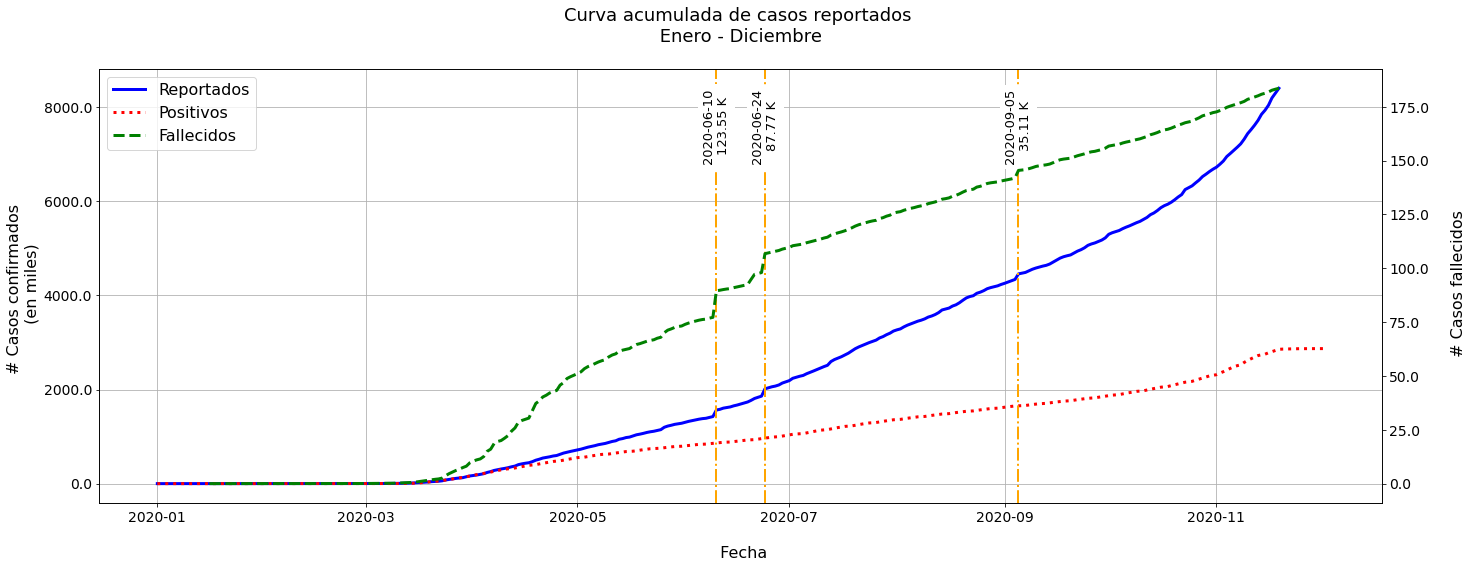

In [ ]:
plt.rcParams['figure.figsize'] = (23,8)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})
fig, ax = plt.subplots()
ax.grid()
lns1 = ax.plot(tabla_fechas_cdc.index,tabla_fechas_cdc,color='blue',linestyle='solid',markersize=7,label='Reportados',linewidth=3)
lns2 = ax.plot(tabla_fechas_pos.index,tabla_fechas_pos,color='red',linestyle='dotted',markersize=7,label='Positivos',linewidth=3)
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax2 = ax.twinx()
lns3 = ax2.plot(tabla_fechas_muertos.index,tabla_fechas_muertos,color='green',linestyle='dashed',markersize=7,label='Fallecidos',linewidth=3)
ax2.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_title('Curva acumulada de casos reportados \n Enero - Diciembre \n',fontsize=18)
ax.set_xlabel('\n Fecha',fontsize=16)
ax.set_ylabel('# Casos confirmados \n (en miles)',fontsize=16)
ax2.set_ylabel('\n # Casos fallecidos',fontsize=16)

for (i,j,k) in zip(fechas,muertos,fechas_aux):
  ax.axvline(x=i,color='orange',linestyle='dashdot',linewidth=2)
  ax.text(i,7600000,k+'\n'+j,rotation='vertical',ha='center',va='center',fontsize=13,backgroundcolor='white')

# Unica leyenda
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left',fontsize=16)

Se puede observar un crecimiento empinado en los meses de abril, junio, setiembre y noviembre lo que coincide con las noticias reportadas en esos meses. (*https://cutt.ly/3jMgthg* : '**Coronavirus en Estados Unidos: 3 claves del "preocupante repunte de contagios**" ', *https://cutt.ly/ujMguiX* : '**Estados Unidos registra 968 muertes por coronavirus en un día**')

Adentrandonos en el mes que se registran los mayores picos de muertos.

In [ ]:
data_critica = data[(data.cdc_report_dt >= pd.to_datetime('2020-06-01')) & (data.cdc_report_dt<= pd.to_datetime('2020-06-30'))] # 880134 filas

Cuenta con 880,134 filas, cabe resaltar la cantidad de casos confirmados x laboratorio (840,466 -> aprox. 95%), vale la pena compara este mes con los demas meses. (Tomar en consideracion # de casos por confirmar en mayo)

In [ ]:
data_critica.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning an

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,Race
count,880134,211321,561235,880134,880131,880120,880134,880134,880134,880134,880134
unique,30,221,324,2,4,10,4,4,4,4,8
top,2020-06-24 00:00:00,2020-06-22 00:00:00,2020-06-15 00:00:00,Laboratory-confirmed case,Female,20 - 29 Years,No,Missing,No,Missing,Unknown
freq,155857,8414,12729,840466,452457,167597,415251,478730,450789,555037,344595
first,2020-06-01 00:00:00,2020-01-04 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-06-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['Periodo'] = pd.to_datetime(data['cdc_report_dt']).dt.to_period('M')

In [ ]:
data_agrupada = data.groupby(by=['Periodo','current_status']).size().unstack()
data_print = round(data_agrupada.div(data_agrupada.sum(axis=1),axis=0)*100,1)
data_print

current_status,Laboratory-confirmed case,Probable Case
Periodo,,
2020-01,88.8,11.2
2020-02,93.2,6.8
2020-03,98.8,1.2
2020-04,95.3,4.7
2020-05,89.0,11.0
2020-06,95.5,4.5
2020-07,96.5,3.5
2020-08,96.0,4.0
2020-09,94.8,5.2


In [ ]:
data_agrupada = data[data['medcond_yn'].isin(['Yes','No'])].groupby(by=['Periodo','medcond_yn']).size().unstack()
data_print = round(data_agrupada.div(data_agrupada.sum(axis=1),axis=0)*100,1)
data_print = data_print.join(data_agrupada,rsuffix='_total')
data_print['Total'] = data_print['No_total'] + data_print['Yes_total']
data_print

medcond_yn,No,Yes,No_total,Yes_total,Total
Periodo,,,,,
2020-01,43.4,56.6,23,30,53
2020-02,39.8,60.2,107,162,269
2020-03,27.9,72.1,14189,36705,50894
2020-04,32.7,67.3,44038,90630,134668
2020-05,43.0,57.0,55877,74149,130026
2020-06,27.4,72.6,55970,148547,204517
2020-07,50.3,49.7,102862,101544,204406
2020-08,56.7,43.3,104573,79957,184530
2020-09,57.2,42.8,89971,67198,157169


In [ ]:
data_agrupada = data[data.death_yn.isin(['Yes','No']) & data.sex.isin(['Male','Female']) & ~data.age_group.isin(['Unknown'])].groupby(by=['sex','age_group','death_yn']).size().unstack()
data_print = round(data_agrupada.div(data_agrupada.sum(axis=1),axis=0)*100,1)
data_print = data_print.join(data_agrupada,rsuffix='_total')
data_print

In [ ]:
data_agrupada = data[data.death_yn.isin(['Yes','No']) & data.sex.isin(['Male','Female']) & ~data.Race.isin(['Unknown'])].groupby(by=['sex','Race','death_yn']).size().unstack()
data_print = round(data_agrupada.div(data_agrupada.sum(axis=1),axis=0)*100,1)
data_print = data_print.join(data_agrupada,rsuffix='_total')
data_print

In [ ]:
data_agrupada = data[data.death_yn.isin(['Yes','No']) & data.medcond_yn.isin(['Yes','No']) & data.hosp_yn.isin(['Yes','No']) & data.icu_yn.isin(['Yes','No'])].groupby(by=['medcond_yn','hosp_yn','icu_yn','death_yn']).size().unstack()
data_agrupada

death_yn                       No    Yes
medcond_yn hosp_yn icu_yn               
No         No      No      246995    550
                   Yes        164      2
           Yes     No       10961    437
                   Yes       2385   1175
Yes        No      No      204488   3983
                   Yes        267     51
           Yes     No       41174   9930
                   Yes      11489  16456

In [ ]:
data.medcond_yn.value_counts()

Missing    6063390
Unknown     838018
Yes         785255
No          718416
Name: medcond_yn, dtype: int64

Analizamos los atributos 

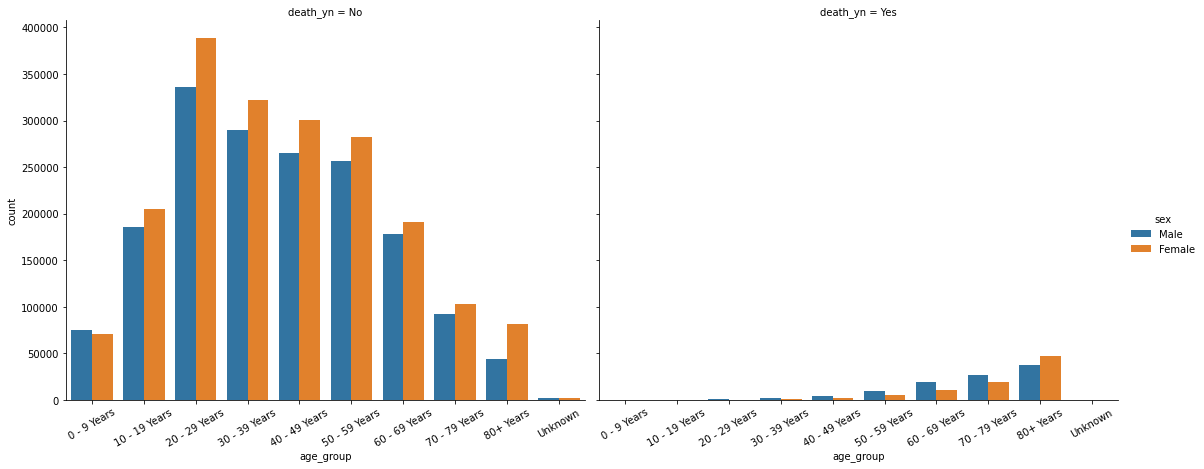

In [ ]:
grafica = sns.catplot(data=data[data.death_yn.isin(['Yes','No']) & data.sex.isin(['Male','Female']) ],
              x='age_group', 
              col='death_yn',
              hue='sex',
              kind='count',
              height=6, aspect=1.3)
grafica.set_xticklabels(rotation=30)

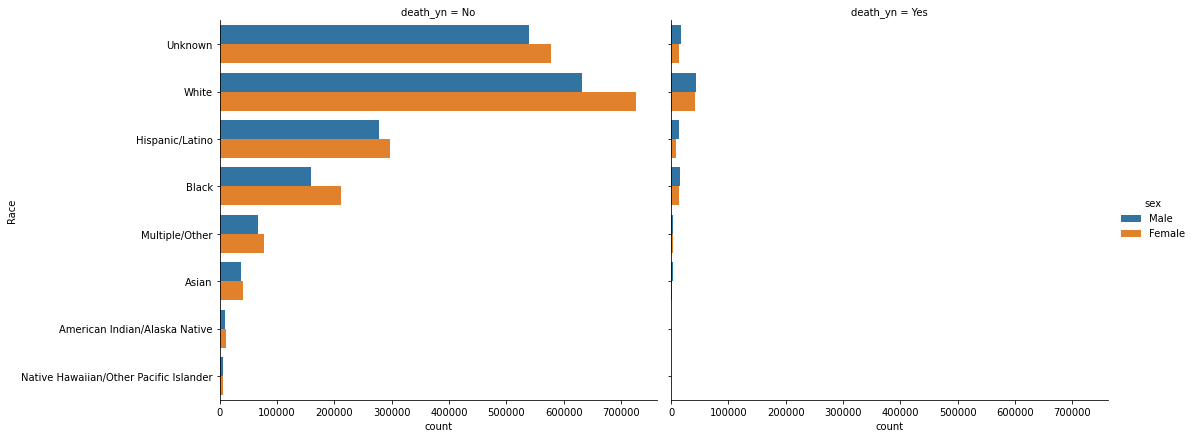

In [ ]:
grafica = sns.catplot(data=data[data.death_yn.isin(['Yes','No']) & data.sex.isin(['Male','Female']) ],
              y='Race', 
              col='death_yn',
              hue='sex',
              kind='count',
              order=data['Race'].value_counts().index,
              height=6, aspect=1.3)

Analizando posible variable a predecir.

Missing    6063390
Unknown     838018
Yes         785255
No          718416
Name: medcond_yn, dtype: int64

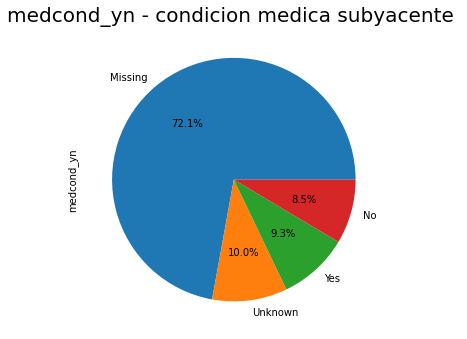

In [ ]:
plt.figure(figsize=(30,10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(141)
plt.title('medcond_yn - condicion medica subyacente ',fontsize = 20)
data['medcond_yn'].value_counts().plot.pie(autopct="%1.1f%%")

data['medcond_yn'].value_counts()

No         3690813
Missing    3486923
Unknown    1043766
Yes         183577
Name: death_yn, dtype: int64

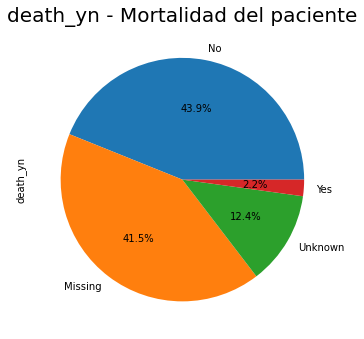

In [ ]:
plt.figure(figsize=(30,10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(141)
plt.title('death_yn - Mortalidad del paciente',fontsize = 20)
data['death_yn'].value_counts().plot.pie(autopct="%1.1f%%")

data['death_yn'].value_counts()

No         3690813
Missing    3486923
Unknown    1043766
Yes         183577
Name: death_yn, dtype: int64

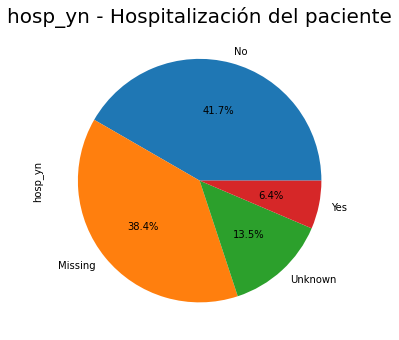

In [ ]:
plt.figure(figsize=(30,10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(141)
plt.title('hosp_yn - Hospitalización del paciente',fontsize = 20)
data['hosp_yn'].value_counts().plot.pie(autopct="%1.1f%%")

data['death_yn'].value_counts()

Missing    6178281
Unknown    1286236
No          879671
Yes          60891
Name: icu_yn, dtype: int64

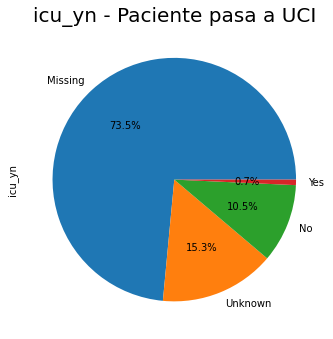

In [ ]:
plt.figure(figsize=(30,10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                      wspace=0.5, hspace=0.2)
plt.subplot(141)
plt.title('icu_yn - Paciente pasa a UCI',fontsize = 20)
data['icu_yn'].value_counts().plot.pie(autopct="%1.1f%%")

data['icu_yn'].value_counts()

Se observaron mucha cantidad de datos faltantes en las variables de fechas **pos_spec_dt** y	**onset_dt** por eso procedemos a eliminarlas


In [ ]:
data = data.drop(['pos_spec_dt','onset_dt'],axis =1)
print(data.shape)

(8405079, 9)


También procedemos a elimnar los valores faltantes al ser un numero minimo de casos respecto a la base

In [ ]:
data.isnull().sum(axis=0)

cdc_report_dt                     0
current_status                    0
sex                              18
age_group                        89
Race and ethnicity (combined)     7
hosp_yn                           0
icu_yn                            0
death_yn                          0
medcond_yn                        0
dtype: int64

In [ ]:
data = data.dropna()

data.isnull().sum(axis=0)

cdc_report_dt                    0
current_status                   0
sex                              0
age_group                        0
Race and ethnicity (combined)    0
hosp_yn                          0
icu_yn                           0
death_yn                         0
medcond_yn                       0
dtype: int64

Se observa que ahora no hay datos faltantes y se tiene una base con 8404990 registros.

In [ ]:
data.describe()

,cdc_report_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
count,8404990,8404990,8404990,8404990,8404990,8404990,8404990,8404990,8404990
unique,321,2,5,10,9,4,4,4,4
top,2020/06/24,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Missing,No,Missing
freq,155856,7910037,4340898,1635264,2781165,3502508,6178240,3690765,6063360


**Antecedente**: Adquisición de conocimiento sobre la letalidad de la COVID-19 mediante técnicas de inteligencia artificial

 http://www.revistaccuba.sld.cu/index.php/revacc/article/view/891/912